# Advection and diffusion in 1D </em>

<em>With applications to climate modeling</em>

# Evolution in time and space: Advection and diffusion in 1D

Simplistic modeling of the Earth's climate will typically look at only 1 variable, temperate, and assumes that temperature is uniform over the entire Earth. But the Earth does not have a single, uniform temperature; rather, at a particular moment in time, different places on Earth are at different temperatures, and those different temperatures change over time due to several mechanisms. 
In this notebook we will look at two fundamental mechanisms: **advection** and **diffusion**. Let's think about the temperature in the ocean. Since the ocean is a fluid that is in motion, a warm "parcel" of water can flow (move) to a new location due to the physical motion of the water itself; this is **advection**.  And even if the water doesn't move, temperature or a higher concentration of some substance dissolved in the fluid can spread out due to molecular mechanisms; this is **diffusion**.

In this notebook we will restrict ourselves to one spatial dimension (1D).
So we will think about the temperature $T$, for example, being a function 
$$T(t, x)$$
of two independent variables:
- time, $t$
- space, $x$

We want to calculate a value of the temperature $T$ for each possible pair of values $(t, x)$, i.e. for all time ($>0$) and all positions.
The temperature at a given point will change due to different physical processes. We need to model this by writing down equations describing each physical process and how it affects the temperature. Since there are now *two* independent variables, $t$ and $x$, we can expect to end up with derivatives with respect to *both* of these variables, so that the rate of change of temperature in time at a given point depends also on gradients of the temperature in *space*. This will lead to a **partial differential equation** that relates *partial* derivatives of $T$.
In the context of climate modelling, we can think of $x$ as being the **latitude**, supposing that the temperature is the same at all points with the same latitude. In this way we could model the fact that the poles are cold and the equator is warm, and we could model how heat flows from hot to cold. 
However, we clearly cannot model actual ocean currents like this, which would require two, or even three, spatial dimensions.

# Temperature profiles and discretization


An ordinary differential equation needs an initial value for each variable. Similarly, we will need an initial *function* $T_0(x)$ that gives us the temperature at each position $x$. Let's suppose that the position is restricted to the interval $[0, L_x]$.
As usual, to represent the continuous function $T_0(x)$ on a computer, we will need to **discretise** it in some way, i.e. *approximate* the continuous function by a *finite* set of numbers in the computer.
The simplest (but far from the only!) discretisation method is to **sample** the function at discrete **grid points** (or **nodes**) $x_i$, for $i = 1, \dots, N_x$. For simplicity we will take these equally spaced, with spacing $x_{i+1} - x_i =: \delta x := L_x / N_x$.

For example, let's consider the following initial temperature profile:

In [1]:
import math
def T_0(x):
    ans = math.sin(2*math.pi * x) + 2*math.cos(4*math.pi * x) + 0.2
    return ans

and define the grid points as follows:

In [2]:
import numpy as np
N_x = 40
L_x = 1.0
	
del_x = L_x / N_x
	
xs = np.arange(del_x/2,L_x,del_x)  # np.arange creates an array from x to y by interval z 

It turns out to be a good idea to take the grid points at the *center* of each interval, so that we have $N_x$ intervals and $N_x$ grid points, starting at $x_1 = \delta x/2$ and finishing at $x_N = L_x - \delta x / 2$.

We can call such a function of $x$ at a given time our **temperature profile**. Let's draw it both as a function and as a heatmap:

In [3]:
T = np.zeros(len(xs))
for i in range(len(xs)):
    T[i] = T_0(xs[i])

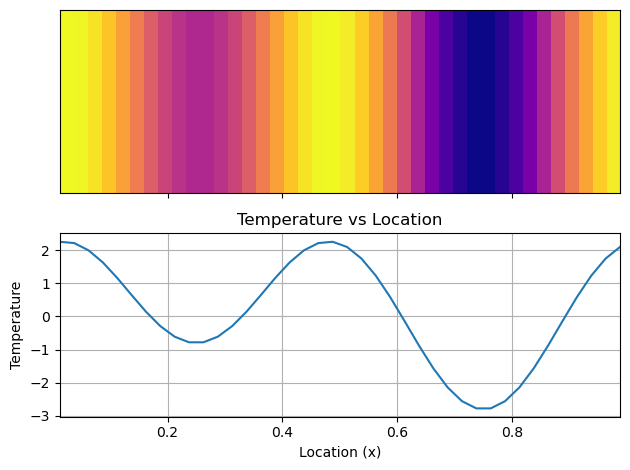

In [4]:
import matplotlib.pyplot as plt
fig, (p1,p2) = plt.subplots(nrows=2, sharex=True)

new_color = "black"   # change the color of the text here if needed
extent = [xs[0], xs[-1], 0 ,1]
p1.imshow(T[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
p1.set_yticks([])
p1.set_xlim(extent[0], extent[1])
plt.tick_params(axis='x', colors = new_color)
plt.tick_params(axis='y', colors = new_color)
plt.title("Heat Map", color = new_color)

p2.plot(xs,T)
plt.grid()
plt.tick_params(axis='x', colors = new_color)
plt.tick_params(axis='y', colors = new_color)
plt.title("Temperature vs Location", color = new_color)
plt.xlabel("Location (x)", color = new_color)
plt.ylabel("Temperature", color = new_color)

plt.tight_layout()
plt.show()

We will denote by $T^0_i$ the initial temperature at grid point number $i$.

A useful way to think about $T^n_i$ is as some kind of (spatial) average of $T(t_n, x)$ over the interval of positions between neighbouring grid points, so $T_i$ is the average over the interval between $x_i - \frac{\delta x}{2}$ and $x_i + \frac{\delta x}{2}$. We can thus think of the following **piecewise constant** approximation to the original continuous function:

Text(0, 0.5, 'T_0(x)')

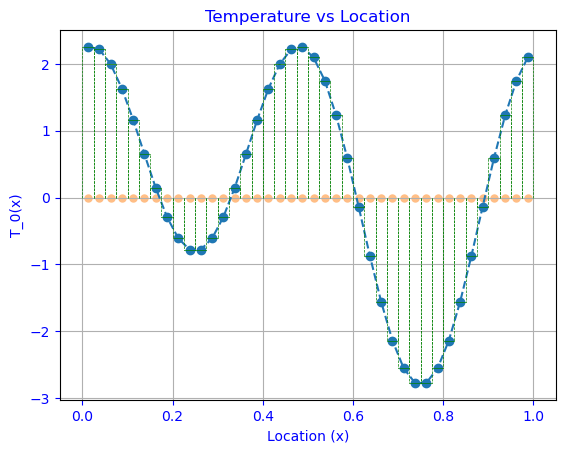

In [5]:
del_x = xs[1] - xs[0]

new_color = "blue"   # change the color of the text here if needed	
plt.plot(xs, T, label="T", linestyle='dashed')
plt.scatter(xs, T, label="sampled")
plt.scatter(xs, np.zeros(len(xs)), label="x nodes", alpha=0.5, color = 'tab:orange', linewidth = del_x)
plt.tick_params(axis='x', colors = new_color)
plt.tick_params(axis='y', colors = new_color)

x = np.zeros(2)
y = np.zeros(2)
for i in range(len(xs)):
    x[0] = xs[i] - del_x/2
    x[1] = xs[i] + del_x/2
    y[0] = T_0(xs[i])
    y[1] = T_0(xs[i])
    plt.plot(x, y, color='green', linewidth = 0.5)
    x[0] = xs[i] - del_x/2
    x[1] = xs[i] - del_x/2
    y[0] = 0
    y[1] = T_0(xs[i])
    plt.plot(x, y, color='green', linestyle = 'dashed', linewidth = 0.5)
    x[0] = xs[i] + del_x/2
    x[1] = xs[i] + del_x/2
    y[0] = 0
    y[1] = T_0(xs[i])
    plt.plot(x, y, color='green', linestyle = 'dashed', linewidth = 0.5)
plt.grid()
plt.title("Temperature vs Location", color = new_color)	
plt.xlabel("Location (x)", color = new_color)
plt.ylabel("T_0(x)", color = new_color)

# Advection

Now let's think of this profile as representing the temperature in each small volume, or "parcel", of fluid. Let's suppose that the fluid is moving to the right with a constant, uniform speed $U$. (**Uniform** here means that the speed is the same in all parts of the fluid.) Then the temperature profile should also *move with the fluid*! We call a quantity, such as the temperature, that is carried along with the fluid a **tracer**.

If we fix our attention at a single, fixed point in space, say the grid point $x_i$, the temperature there will vary over time, due to the fact that the fluid is moving past it. How it varies in time depends on the values at neighbouring grid points, since they determine how much heat will be transported *into* and *out of* the current cell.
[When it comes to modeling, the point of view where we fix our attention at one point in space is called **Eulerian**. The alternative is to follow a parcel of fluid as it moves along in space; this is called **Lagrangian**.]

## Time stepping
We want to model how the temperature profile changes in time due to the flow of the fluid. We'll do so by looking at each cell and asking how much heat enters and leaves the cell in a given time step, of duration $\delta t$.


Let's call $T^n_i$ the approximate (unknown) average value of $T$ in the cell at position $x_i$ and at the $n$th time step $t_n$, i.e. an approximation of $T(t_n, x_i)$, where $t_n = n \, \delta t$. 

Then $T^{n+1}_i \simeq T(t_n + \delta t, x_i)$ and $T^{n}_{i+1} \simeq T(t_n, x_i + \delta x)$.

[Note that the superscript $n$ in these algorithms does not mean a power; it's just a label for the time step. We could write $T_i^{(n)}$ instead, but that is annoying to both write and read, so we omit the parentheses.]

Suppose the fluid is moving to the right with speed $U$. During a time step of duration $\delta t$, the temperature $T^n_i$ at cell $i$ changes for two reasons:
- some heat enters cell $i$
- some heat leaves cell $i$ 

Note that most of the fluid that starts within cell $i$ remains within that cell during the time step (if the time step is short enough). 
To calculate how much heat enters and leaves, note that only heat in the region of fluid within a distance $U \, \delta t$ from the boundary of the cell will cross into that cell. 

So a *proportion* $(U \, \delta t) / \delta x$ of the amount in cell $i$ crosses the boundary.
[We will blur the distinction between "amount of heat" and temperature.]
Hence, roughly an amount $T^n_i (U \delta t) / \delta x$ will leave cell number $i$ and cross into cell $i+1$ (the cell to the right). 

Similarly, an amount $T^n_{i-1} (U \delta t) / \delta x$ will *enter* cell $i$ from the neighbouring cell $i-1$ on the left. 
Hence we arrive at the following:
$$T^{n+1}_i = T^{n}_i + (T^n_{i-1} - T^n_{i})\, U \, \delta t / \delta x.$$
Note that on the right-hand side we have quantities at the time step $n$, and on the left at time step $n+1$. So this tells us how to *update* our quantities from slice $n$ to slice $n+1$.



## Continuous limit: Advection equation PDE

Rearranging the previous equation we get 
$$\frac{T^{n+1}_i - T^{n}_i}{\delta t} =  \frac{T^n_{i-1} - T^n_{i}}{\delta x}\,  U.$$


Taking the continuum limit when $\delta t \to 0$ and $\delta x \to 0$, we recognise the definition of **partial derivatives** with respect to time and space variables from multivariable calculus. (Note the different indices that change on the two sides of the equation.) 
Denoting these partial derivatives using $\partial$, we arrive at the **advection equation**:
$$\frac{\partial T(t, x)}{\partial t} = -U \frac{\partial T(t, x)}{\partial x},$$
or for short
$$\frac{\partial T}{\partial t} = -U \frac{\partial T}{\partial x}.$$
Since $T$ is a function of both $x$ and $t$, and this equation involves partial derivatives with respect to both of the independent variables, this is a **partial differential equation** (PDE). It describes how the function $T(t, x)$ changes continuously as a function both of time and space.

Although there are some analytical methods to solve PDEs, often it's necessary to use numerical methods. Here we'll look at simple numerical methods to solve such equations.

## Numerics for the advection equation

Let's return to the version of the equation in which the value at the *following* time step is isolated:
$$T^{n+1}_i = T^{n}_i - \left( U \frac{\delta t}{\delta x} \right) (T^n_{i} - T^n_{i-1}).$$
In the last term on the right-hand side, we see that we require combinations of values of $T$ at the *same* time step from *different* places, with certain coefficients.


There are many approaches to implementing this numerically. The simplest is to directly transcribe the equation for the $i$th entry of the vector.

Calling `T` the current vector, i.e. $\mathbf{T}^n := (T^n_i)_{i=1, \ldots, N_x}$, and `T′` the new vector at the next time step, we have the following basic expression:

`T′[i]` = `T[i]` + `δt` * U * `(T[i-1] - T[i])/δx`

But now we realise a problem: What should we do when $i=1$? This will try to access the index 0 of the vector `T`, which does not exist!


### **Boundary conditions**

This illustrates the necessity of choosing **boundary conditions** that specify what happens at the edge of the domain.
For simplicity we will choose to use **periodic boundary conditions**. This is a convenient mathematical fiction that allows us to treat all cells as being on the same footing, by wrapping the system around a torus, so that cells $i=1$ and $i=N_x$ are neighbours.

We can then write this as follows, where we separate out the case $i=1$:

In [6]:
def advection(T, del_t, del_x, U):
    for i in range(len(T)):
        if i < 1:
            T_new[0] = T[0] - (del_t * U * (T[0] - T[-1]) / del_x)   
        else: 
            T_new[i] = T[i] - (del_t * U * (T[i] - T[i-1]) / del_x)

    return T_new

This performs a single time step of the advection equation; it takes in the current vector of $T$s and returns the new $T$s after the step.

Note that this is just like a step of the Euler method for solving ODEs, but where many spatial coordinates are updated at the same time. Effectively we are solving a system of coupled ODEs!

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def time_widget(tspan=0.01):
    
    #tspan = 2
    del_t = 0.001
    U = 0.2
    j = np.arange(0,tspan,del_t)
    # remember, xs is our location value from earlier
    # T is our initial temps at each location
    T_new = np.zeros(len(T))   # we don't want to overwrite our initial T

    for k in range(len(j)):
        if k < 1:
            T_new = advection(T, del_t, del_x, U)
        T_new = advection(T_new, del_t, del_x, U)
    
    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    line, = plt.plot(xs, T, lw=1)
    line, = plt.plot(xs, T_new, lw=1, color = 'green')
    plt.scatter(xs, T_new, label="sampled")
    ax.set_ylim(-3.0, 3.0)
    plt.grid()
    plt.tick_params(axis='x', color = new_color)
    plt.tick_params(axis='y', color = new_color)
    plt.title("Temperature vs Location", color = new_color)
    plt.xlabel("Location (x)", color = new_color)
    plt.ylabel("Temperature", color = new_color)

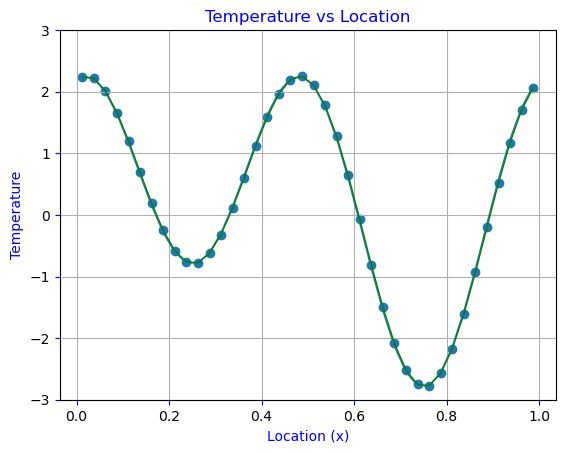

interactive(children=(FloatSlider(value=0.01, description='tspan', max=10.0, min=0.01, step=0.01), Output()), …

<function __main__.time_widget(tspan=0.01)>

In [8]:
T_new = np.zeros(len(T))
widgets.interact(time_widget, tspan=(0.01, 10, 0.01));

Unfortunately this does *not* behave as we expect: instead of preserving the shape of the profile over time, it is decaying. This is due to the way we are approximating.
 
A better way to discretize the spatial derivative is using the following **centered difference**:
$$\frac{\partial T(t_n, x_i)}{\partial x} \simeq \frac{T^n_{i+1} - T^n_{i-1}}{2 \delta x}$$

Use the cell below to create a new advection function (advection2) that uses the centered difference method. 

In [9]:
def advection2(T, del_t, del_x, U):
	for i in range(len(T)):
		if i==0:
			T_new[0] = T[0] - (del_t * U * (T[1] - T[-1]) / (2*del_x))  			
		elif i==len(T)-1:
			T_new[len(T)-1] = T[len(T)-1] - (del_t * U * (T[0] - T[len(T)-2]) / (2*del_x))
		else:
			T_new[i] = T[i] - (del_t * U * (T[i+1] - T[i-1]) / (2*del_x))
			
	return T_new


In [10]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def time_widget_2(tspan=0.01):
    
    #tspan = 2
    del_t = 0.001
    U = 0.2
    j = np.arange(0,tspan,del_t)
    # remember, xs is our location value from earlier
    # T is our initial temps at each location
    T_new = np.zeros(len(T))   # we don't want to overwrite our initial T

    for k in range(len(j)):
        if k < 1:
            T_new = advection2(T, del_t, del_x, U)
        T_new = advection2(T_new, del_t, del_x, U)
    
    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    line, = plt.plot(xs, T, lw=1)
    line, = plt.plot(xs, T_new, lw=1, color = 'green')
    plt.scatter(xs, T_new, label="sampled")
    ax.set_ylim(-3.0, 3.0)
    plt.grid()
    plt.tick_params(axis='x', color = new_color)
    plt.tick_params(axis='y', color = new_color)
    plt.title("Temperature vs Location", color = new_color)
    plt.xlabel("Location (x)", color = new_color)
    plt.ylabel("Temperature", color = new_color)

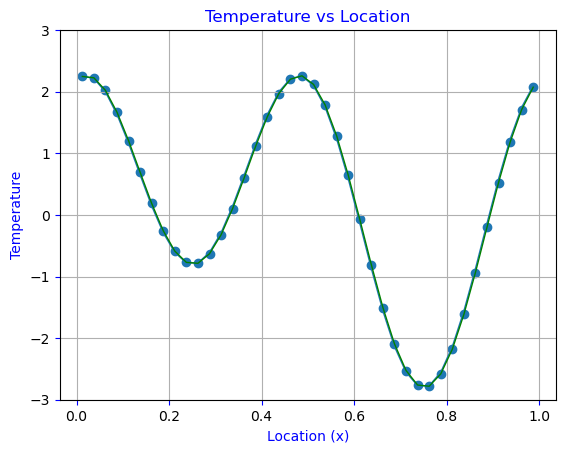

interactive(children=(FloatSlider(value=0.01, description='tspan', max=10.0, min=0.01, step=0.01), Output()), …

<function __main__.time_widget_2(tspan=0.01)>

In [11]:
widgets.interact(time_widget_2, tspan=(0.01, 10, 0.01));

Does your result behave as expected? 
<font color = 'blue'>
Yes it does, the plot preserves its shape. It makes sense that the central difference does this as the local maxima are located between out actual discrete values. 
</font>


# Diffusion

Another key physical process is **diffusion**. This models how temperature or mass spreads out from hot or high concentration regions towards regions where it is cold or where there is a low concentration.



## Physical mechanism: Random walks

The physical mechanism behind this is **random motion**: this is the continuous limit of equations describing the evolution of the probability distribution in space and time of a cloud of random walkers.

Using our current notation, there we showed that the probability distribution of a cloud of random walkers satisfies the following time evolution:
$$p^{n+1}_i = \frac{1}{2}(p^n_{i-1} + p^n_{i+1})$$

If now we say that the walkers jump only with a certain probability, with a large probability to stay in the same place, and that these random walkers are the carriers of heat, then we get:

$$T^{n+1}_i = \kappa (T^n_{i-1} - 2 T^n_i + T^n_{i+1}).$$

You can watch [this video](https://www.youtube.com/watch?v=a3V0BJLIo_c) from Grant Sanderson explaining this.


## Continuous limit: Heat equation PDE

Introducing $\delta x$ as the spatial discretisation, and $\delta t$ as the time step, we get 
$$T^{n+1}_i = \kappa \frac{\delta t}{\delta x^2}  (T^n_{i-1} - 2 T^n_i + T^n_{i+1}).$$

The continuous limit is the following **heat equation** or **diffusion equation**:

$$\frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2}.$$

Here, $\kappa$ is the **heat diffusivity**, which says how quickly heat spreads out. In the context of diffusion of mass the equivalent is the **diffusion coefficient**, $D$.


To obtain a numerical method to solve this equation, we again need to discretise this, in particular the second derivative. One possible discretisation is:

$$\frac{\partial^2 T}{\partial x^2}(t_n, x_i) \simeq \frac{T^n_{i+1} - 2 T^n_i + T^n_{i-1}}{\delta x^2}.$$

This may again be transcribed directly into code:

In [12]:
def diffusion(T, del_t, del_x, D):
	
    for i in range(len(T)):
        if i >= 1 and i < len(T)-1:
            T_new[i] = T[i] + del_t * D * (T[i+1] -2*T[i] + T[i-1]) / (del_x**2)
	# periodic boundary:
    T_new[0] = T[0] + del_t * D * (T[1] - 2*T[0] + T[-1]) / (del_x**2) 
    T_new[-1] = T[-1] + del_t * D * (T[0] - 2*T[-1] + T[-2]) / (del_x**2)
     
    return T_new

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def diffusion_widget_1(tspan=0.01):
    
    #tspan = 2
    del_t = 0.001
    D = 0.01
    j = np.arange(0,tspan,del_t)
    # remember, xs is our location value from earlier
    # T is our initial temps at each location
    T_new = np.zeros(len(T))   # we don't want to overwrite our initial T

    for k in range(len(j)):
        if k < 1:
            T_new = diffusion(T, del_t, del_x, D)
        T_new = diffusion(T_new, del_t, del_x, D)
    
    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    line, = plt.plot(xs, T, lw=1)
    line, = plt.plot(xs, T_new, lw=1, color = 'green')
    plt.scatter(xs, T_new, label="sampled")
    ax.set_ylim(-3.0, 3.0)
    plt.grid()
    plt.tick_params(axis='x', color = new_color)
    plt.tick_params(axis='y', color = new_color)
    plt.title("Temperature vs Location", color = new_color)
    plt.xlabel("Location (x)", color = new_color)
    plt.ylabel("Temperature", color = new_color)

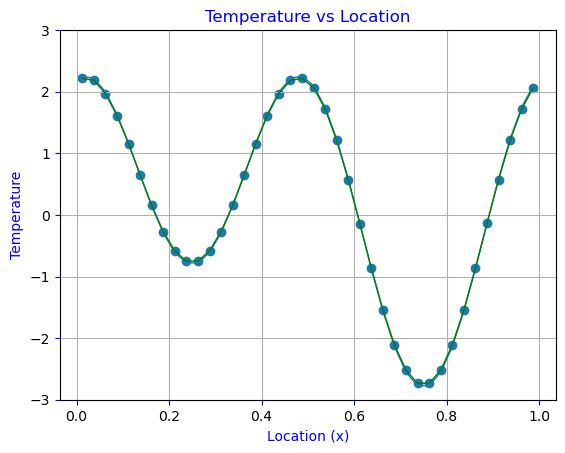

interactive(children=(FloatSlider(value=0.01, description='tspan', max=10.0, min=0.01, step=0.01), Output()), …

<function __main__.diffusion_widget_1(tspan=0.01)>

In [14]:
widgets.interact(diffusion_widget_1, tspan=(0.01, 10, 0.01))

# The advection-diffusion PDE

Finally we can combine both mechanisms to describe a tracer that is both being advected at a constant speed and diffusing. This basically utilises the composition of the advection and diffusion functions. 

In [15]:
def advection_diffusion(T, del_t, del_x, U, D):
	temp = advection2(T, del_t, del_x, U)
	return diffusion(temp, del_t, del_x, D)

Using either subplot or ipywidgets to show how our wave changes over time due to advection-diffusion processes. Is the result what you would expect?

In [16]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def AdvDiff_widget(tspan=0.01):

    del_t = 0.001
    D = 0.01
    U = 2
    j = np.arange(0,tspan,del_t)
    # remember, xs is our location value from earlier
    # T is our initial temps at each location
    T_new = np.zeros(len(T))   # we don't want to overwrite our initial T

    for k in range(len(j)):
        if k<1:
            T_new = advection_diffusion(T, del_t, del_x, U, D)
        T_new = advection_diffusion(T_new, del_t, del_x, U, D)
    
    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    line, = plt.plot(xs, T, lw=1)
    line, = plt.plot(xs, T_new, lw=1, color = 'green')
    plt.scatter(xs, T_new, label="sampled")
    ax.set_ylim(-3.0, 3.0)
    plt.grid()
    plt.tick_params(axis='x', color = new_color)
    plt.tick_params(axis='y', color = new_color)
    plt.title("Temperature vs Location", color = new_color)
    plt.xlabel("Location (x)", color = new_color)
    plt.ylabel("Temperature", color = new_color)
   

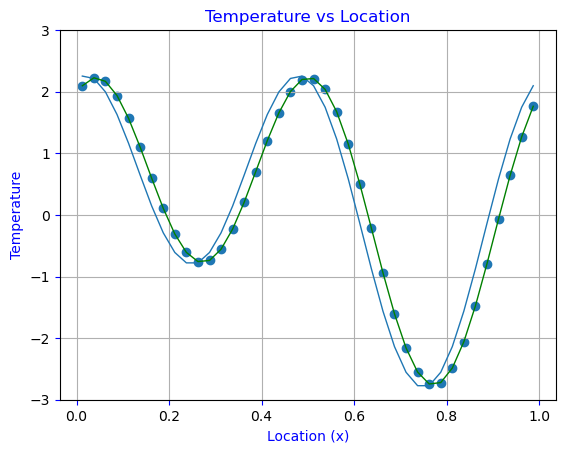

interactive(children=(FloatSlider(value=0.01, description='tspan', max=10.0, min=0.01, step=0.01), Output()), …

<function __main__.AdvDiff_widget(tspan=0.01)>

In [17]:
widgets.interact(AdvDiff_widget, tspan=(0.01, 10, 0.01))